In [2]:
from matplotlib import pyplot as plt, animation
import numpy as np
import pysindy as ps
from math import pi
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField

In [3]:
def plot_solution(x, y, u, main_str, t=0):
    plt.figure()
    plot_u = np.transpose(u, (0, 2, 1))
    plt.pcolormesh(x, y, plot_u[t], vmin=-1, vmax=1)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.title(main_str, fontsize=16)
    plt.colorbar()

def animate_solution(x, y, u, main_str, file_name):
    fig, ax = plt.subplots()
    ax.set_xlabel("x", fontsize=16); ax.set_ylabel("y", fontsize=16)
    ax.set_title(main_str, fontsize=16)

    plot_u = np.transpose(u, (0, 2, 1))
    cax = ax.pcolormesh(x, y, plot_u[0,:,:], vmin=-1, vmax=1)
    fig.colorbar(cax)
    
    def change_frame(i):
        cax.set_array(plot_u[i,:,:].flatten())
    
    anim = animation.FuncAnimation(fig, change_frame, interval=100, frames=len(u[:,0,0]) - 1)
    anim.save(file_name)

In [4]:
a = 1  # wave speed in x direction  --- do these actually work?
b = 1  # wave speed in y direction
equation = PDE({"u": f"- {a} * d_dx(u) - {b} * d_dy(u)"},
                # bc={"value": "cos(x)"}
                )

x_min = 0
x_max = pi*2
x_num_elements = 4

y_min = -pi
y_max = pi
y_num_elements = 4

grid = CartesianGrid([[x_min, x_max], [y_min, y_max]], [x_num_elements, y_num_elements], periodic=True)
state = ScalarField.from_expression(grid, "cos(x+2*y)")

t_max = pi
t_num_elements = 64

storage = MemoryStorage()
result = equation.solve(state, t_range=t_max, tracker=storage.tracker(t_max/t_num_elements))

[x, y] = storage.grid.axes_coords
t = np.ravel(storage.times)
u = np.real(storage.data)

In [5]:
u.shape

(65, 4, 4)

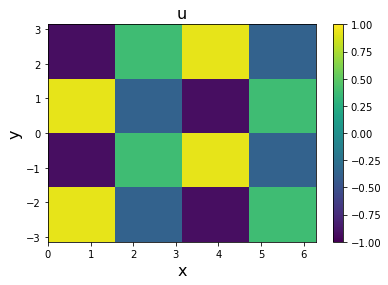

In [6]:
animate_solution(x, y, u, "u", "wave.gif")

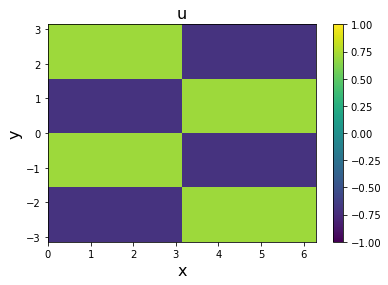

In [11]:
plot_solution(x, y, u, "u")

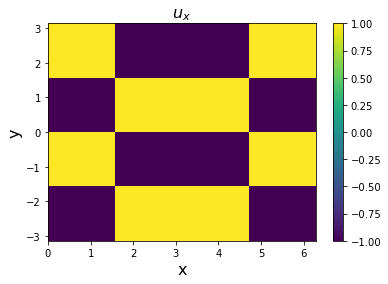

In [12]:
dt = t[1] - t[0]
for i in range(1, 2):
    u_i = ps.FiniteDifference(d=i, axis=1)._differentiate(u, t=dt)
    plot_solution(x, y, u_i, "$u_{{{}}}$".format("x"*i))

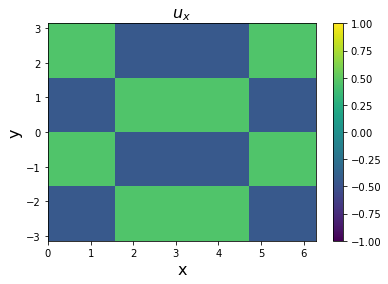

In [13]:
dx = x[1] - x[0]
for i in range(1, 2):
    u_i = ps.FiniteDifference(d=i, axis=1)._differentiate(u, t=dx)
    plot_solution(x, y, u_i, "$u_{{{}}}$".format("x"*i))

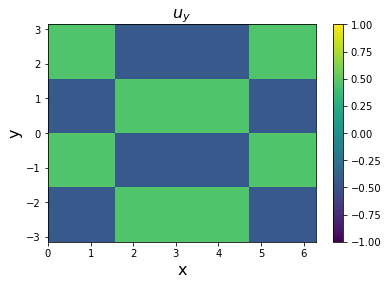

In [14]:
dy = y[1] - y[0]
for i in range(1, 2):
    u_i = ps.FiniteDifference(d=i, axis=1)._differentiate(u, t=dy)
    plot_solution(x, y, u_i, "$u_{{{}}}$".format("y"*i))

In [19]:
u = u.reshape(len(x), len(y), len(t), 1)

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x, 
                        include_bias=True, is_uniform=True
                        )

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=100, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,
                #  differentiation_method=ps.SpectralDerivative
                 )
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = -7.360 x0_1


In [20]:
pde_lib.get_feature_names()

['1',
 'x0',
 'x0x0',
 'x0_1',
 'x0_11',
 'x0x0_1',
 'x0x0x0_1',
 'x0x0_11',
 'x0x0x0_11']

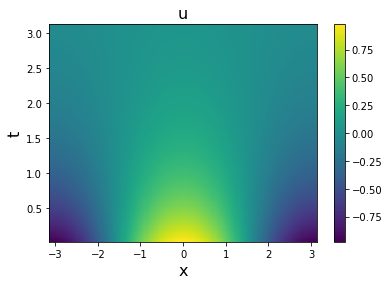

In [375]:
u_reduced = np.real(storage.data)[2:-2, :]

plot_solution(x, t[2:-2], u_reduced, "u")

In [376]:
u_r = u_reduced.reshape(len(x), len(t)-4, 1)
model2 = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model2.fit(u_r, t=dt)
model2.print()

(x0)' = -0.333 x0 + -0.667 x0_1
